# Нейросетевые модели поиска. Часть II. Переранжирование.
## Домашнее задание

В этом задании вам предстоит обучить модели переранжирования с архитектурой cross-encoder и bi-encoder на датасете [VK MARCO](https://cloud.mail.ru/public/MQ3H/GVGeAWZoj). За его решение можно получить до 10 баллов, а также еще 10 бонусных за выполнение дополнительных заданий.

**Вам надо:**

- Форкнуть эту репу;
- Создать бранч, в котором вы дальше будете работать;
- Выполнить все или часть заданий ноутбука;
- Запушить ваш бранч и поставить Pull Request.

Проверяющий счекаутит вашу бранчу и проверит работу.

**Замечания:**

- При выполнении задания можете использовать код из соответствующего семинара;
- Вам предстоит сделать как минимум 2 обучения (а при выполнении дополнительных заданий и того больше), постарайтесь переиспользовать код и минимизировать копипасты;
- Старайтесь писать чистый и понятный код, не оставляйте в ноутбуке лишний мусор (выводы ячеек с pip install, ненужный закомментированный код и т.д.);
- При сдаче дз сохраните выходы ячеек с логами обучения и графиками. Если для построения графиков вы использовали tensorboard, то вставьте графики в ноутбук в виде скриншотов;
- Итоговый ноутбук должен быть работоспособен, то есть проверяющий должен иметь возможность запустить все его ячейки в том порядке, в котором они распологаются в ноутбуке, и получить результаты, аналогичные вашим.


### Данные [1 балл]

Скачайте и распакуйте датасет [VK MARCO](https://cloud.mail.ru/public/MQ3H/GVGeAWZoj). Архив содержит следующие файлы (формат аналогичен MS MARCO):
* vkmarco-docs.tsv - tsv с текстами документов;
* vkmarco-doctrain-queries.tsv - tsv с текстами запросов;
* vkmarco-doctrain-qrels.tsv - tsv с оценками релевантности запроса и документа;
* Аналогичный набор файлов для валидации.

Загрузите данные трейна и валидации в pandas.DataFrame так, чтобы он содержал следующие колонки:
* qid - id запроса;
* query - текст запроса;
* text - текст документа;
* label - оценка релевантности запроса и документа.

In [1]:
import tarfile
import subprocess
from pathlib import Path

for file in Path("../../data/vkmarcoranking-v1-document").glob("*.gz"):
    subprocess.run(["gunzip", str(file)])

### Baselines \[2 балла\]

Реализуйте подсчет метрик MRR@k и NDCG@k. Посчитайте их значения на валидационном сете для нескольких бейзлайнов:
1. Модель, делающая случайное предсказание;
1. BM25.

In [2]:
import torch
import numpy as np

from rank_bm25 import BM25Okapi
from nltk.tokenize import WordPunctTokenizer
from tqdm.notebook import tqdm
from torchmetrics.retrieval import RetrievalMRR, RetrievalNormalizedDCG
from lightning import seed_everything

seed=1337
seed_everything(seed)

def MRR(preds, target, qids, top_k=10, threshold=1):
    mrr = RetrievalMRR(top_k=top_k)
    tresholded_target = np.where(target>threshold, 1, 0)
    return mrr(torch.Tensor(preds), 
               torch.Tensor(tresholded_target), 
               indexes=torch.LongTensor(qids - min(qids)))

def NDCG(preds, target, qids, top_k=10):
    ndcg = RetrievalNormalizedDCG(top_k=top_k)

    return ndcg(torch.Tensor(preds), 
               torch.Tensor(target), 
               indexes=torch.LongTensor(qids - min(qids)))


Seed set to 1337


In [3]:
from pathlib import Path
import pandas as pd

DATA_PATH = Path("../../data/vkmarcoranking-v1-document/")

train_queries_df = pd.read_csv(Path(DATA_PATH, 'vkmarco-doctrain-queries.tsv'), sep='\t', header=None, names=['qid', 'query'])
dev_queries_df = pd.read_csv(Path(DATA_PATH, 'vkmarco-docdev-queries.tsv'), sep='\t', header=None, names=['qid', 'query'])

train_qrels_df = pd.read_csv(Path(DATA_PATH, 'vkmarco-doctrain-qrels.tsv'), sep=' ', header=None, names=['qid', 'Q0', 'docid', 'label'], usecols=['qid', 'docid', 'label'])
dev_qrels_df = pd.read_csv(Path(DATA_PATH, 'vkmarco-docdev-qrels.tsv'), sep=' ', header=None, names=['qid', 'Q0', 'docid', 'label'], usecols=['qid', 'docid', 'label'])

docs_df = pd.read_csv(Path(DATA_PATH, 'vkmarco-docs.tsv'), sep='\t', header=None, names=['docid', 'url', 'title', 'body'])

train_merged_df = pd.merge(train_queries_df, train_qrels_df, on='qid')
train_merged_df = pd.merge(train_merged_df, docs_df[['docid', 'title', 'body']], on='docid')
train_merged_df.rename(columns={'body': 'text'}, inplace=True)

dev_merged_df = pd.merge(dev_queries_df, dev_qrels_df, on='qid')
dev_merged_df = pd.merge(dev_merged_df, docs_df[['docid', 'title', 'body']], on='docid')
dev_merged_df.rename(columns={'body': 'text'}, inplace=True)

print(train_merged_df.head())
print(dev_merged_df.head())


    qid                                    query       docid  label  \
0  1857  акватекс электромаш в москве умывальник  D000039278      3   
1  1857  акватекс электромаш в москве умывальник  D000039279      3   
2  1857  акватекс электромаш в москве умывальник  D000039280      1   
3  1857  акватекс электромаш в москве умывальник  D000039281      3   
4  1857  акватекс электромаш в москве умывальник  D000039282      3   

                                               title  \
0               Умывальники Акватекс купить в Москве   
1  Умывальник для дачи Акватекс Электромаш с подо...   
2  Умывальник акватекс с подогревом нерж. мойка м...   
3  Завод Электромаш: Дачные умывальники Акватекс,...   
4  Умывальники дачные Акватекс купить по низкой ц...   

                                                text  
0  Купить умывальники акватекс﻿ недорого в Москве...  
1  Умывальник для дачи Акватекс Электромаш с подо...  
2  Выбирайте товары в категории Умывальник аквате...  
3  Завод «Электр

In [4]:
train_merged_df = train_merged_df.sort_values(by="qid").reset_index(drop=True)
dev_merged_df = dev_merged_df.sort_values(by="qid").reset_index(drop=True)
train_merged_df.to_csv("train.csv", index=False)
dev_merged_df.to_csv("dev.csv", index=False)

In [ ]:
def get_bm25_model_predictions(dataset):
    tokenizer = WordPunctTokenizer()
    tokenized_corpus = [tokenizer.tokenize(doc) for doc in dataset['text'].values]
    bm25 = BM25Okapi(tokenized_corpus)

    queries = dataset['query'].unique()
    bm25_preds = np.zeros(len(dataset))
    for query in tqdm(queries):
        tokenized_query = tokenizer.tokenize(query)
        doc_scores = bm25.get_scores(tokenized_query)
        mask = dataset['query'] == query
        bm25_preds[mask] = doc_scores[mask]
    return bm25_preds

bm25_model_predictions = get_bm25_model_predictions(dev_merged_df)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
random_predictions = np.random.random(len(dev_merged_df))
random_predictions

array([0.26202468, 0.15868397, 0.27812652, ..., 0.02598355, 0.93506049,
       0.19883656])

In [8]:
res_df = pd.DataFrame(columns=["metric", "top_k", "alg_name", "value"])
for k in [1, 5, 10, 25]:
    res_df.loc[len(res_df)] = ["MRR", k, "bm25", MRR(bm25_model_predictions, dev_merged_df['label'].values, dev_merged_df['qid'].values, top_k=k, threshold=2).item()]
    res_df.loc[len(res_df)] = ["NDCG", k, "bm25", NDCG(bm25_model_predictions, dev_merged_df['label'].values, dev_merged_df['qid'].values, top_k=k).item()]
    res_df.loc[len(res_df)] = ["MRR", k, "random", MRR(random_predictions, dev_merged_df['label'].values, dev_merged_df['qid'].values, top_k=k, threshold=2).item()]
    res_df.loc[len(res_df)] = ["NDCG", k, "random", NDCG(random_predictions, dev_merged_df['label'].values, dev_merged_df['qid'].values, top_k=k).item()]
    res_df.sort_values(by=["metric", "alg_name", "top_k"])

,metric,top_k,alg_name,value
0,MRR,1,bm25,0.130600
4,MRR,5,bm25,0.217213
8,MRR,10,bm25,0.235509
12,MRR,25,bm25,0.244218
2,MRR,1,random,0.121800
6,MRR,5,random,0.205487
10,MRR,10,random,0.223129
14,MRR,25,random,0.233302
1,NDCG,1,bm25,0.577012
5,NDCG,5,bm25,0.638980


### Обучение cross-encoder \[2 балла\]

Выполните следующие задания:
* Обучите модель xlm-roberta-base в фомате cross-encoder.
* Постройте графики зависимости метрик от количества пройденных шагов.
* Посчитайте метрики для финальной модели.
* Сколько времени заняло обучение?

Код обучения находится в папке ranking_lib. Ставить эксперименты в ноутбуке очень неудобно :(
    
* Модели: ranking_lib/models/
* Lightning trainer: ranking_lib/lightning_wrappers
* Датасет и препроцессинг: ranking_lib/dataset/

#### Ответы

Графики обучений и расчитанные метрики находятся [здесь](https://wandb.ai/dreminm/nn-reranking/reports/Dremin-nn-reranking-homework--Vmlldzo3NjcxMDcz)

Нейминг экспериментов
* <название модели> - crossencoder fp32
* <название модели>-bi_encoder - bi-encoder fp32
* <название модели>...-fp-16 - модель с AMP fp16

Запуск обучения:

`python train.py lightning.model.model_name="xlm-roberta-base" exp_name="xlm-roberta-base-fp16" datamodule.train_dataloader.batch_size=96 ++trainer.precision=16`

`xlm-roberta-base`: 
* NDCG@3=0.69
* NDCG@10=0.756
* MRR@3=0.681
* MRR@10=0.702

`bert-multilingual-passage-reranking-msmarco`
* NDCG@3=0.698
* NDCG@10=0.762
* MRR@3=0.69
* MRR@10=0.711

Еще была попробована модель rubert-tiny2, так как у нее длинный контекст (2048 токенов) и хорошие результаты на бенчмарке encodechka, но там все не так радужно

Для подсчета MRR лейблы бинаризовались по трешхолду >=2

* Сколько времени заняло обучение?
15к итераций заняли 6 часов обучения для каждой модели

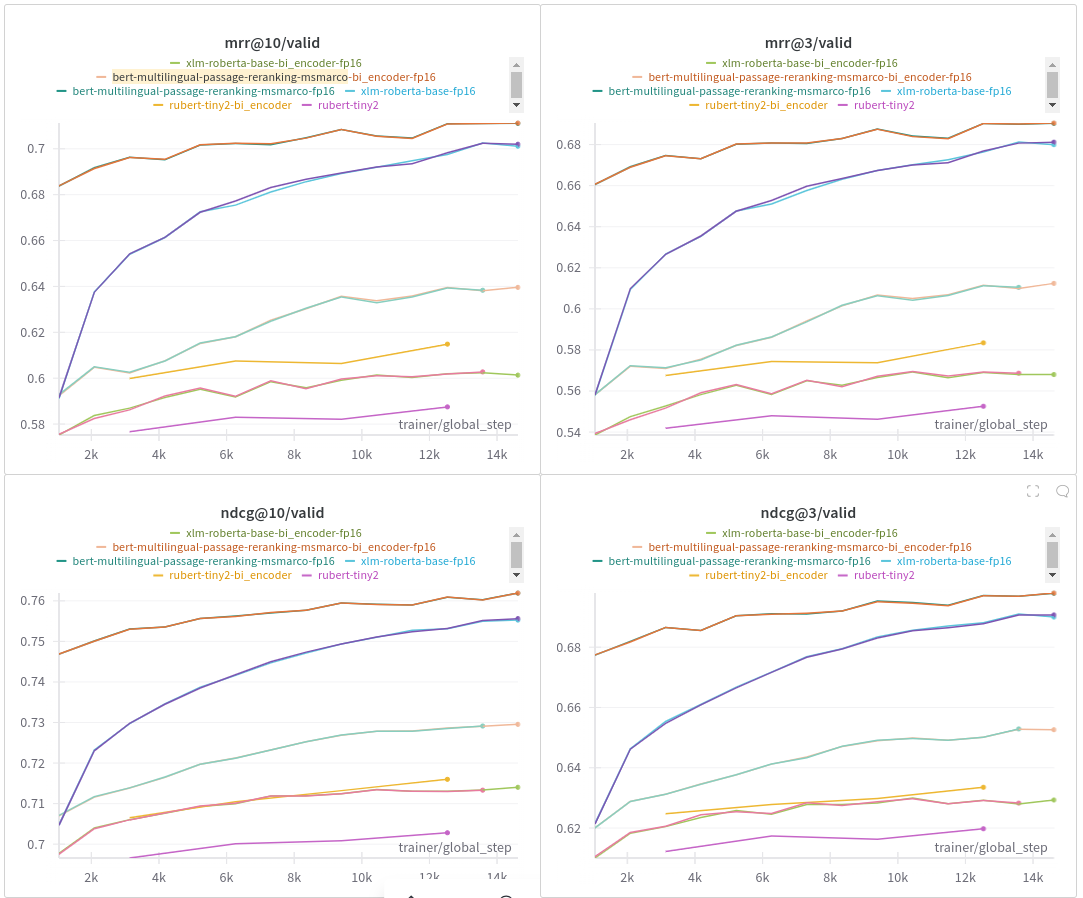

### Обучение bi-encoder \[4 балла\]

Вспомним, что разница между cross-encoder и bi-encoder моделями заключается способе получения скора релевантности:

| Cross-encoder | Bi-encoder |
| - | - |
| 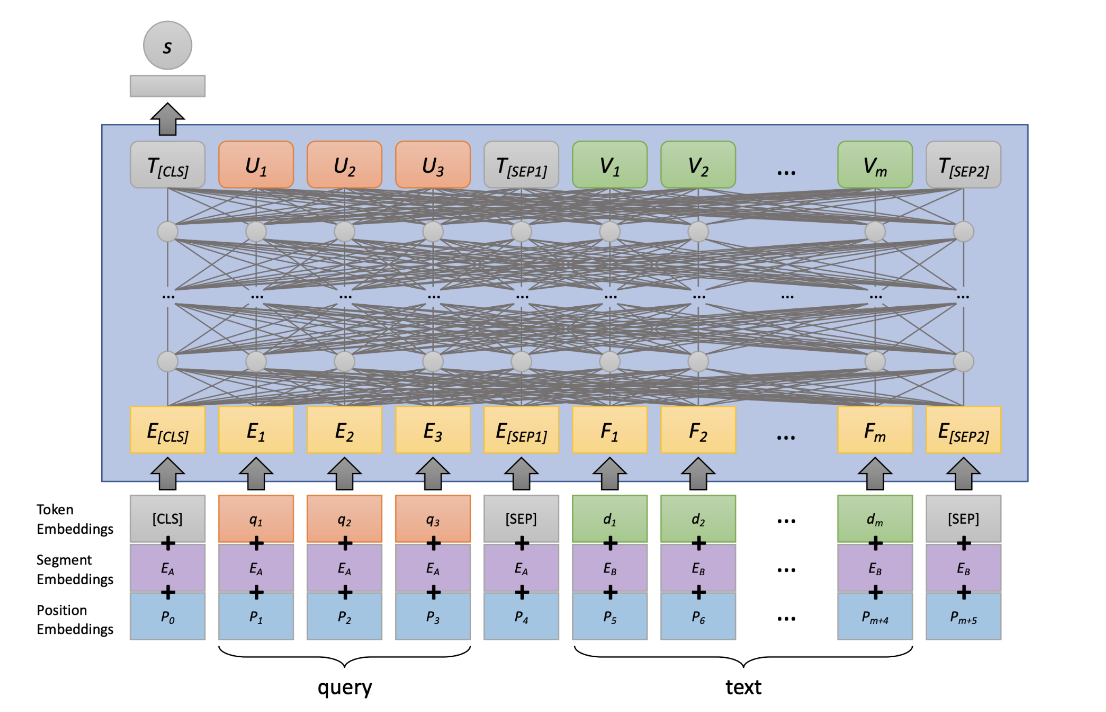 | 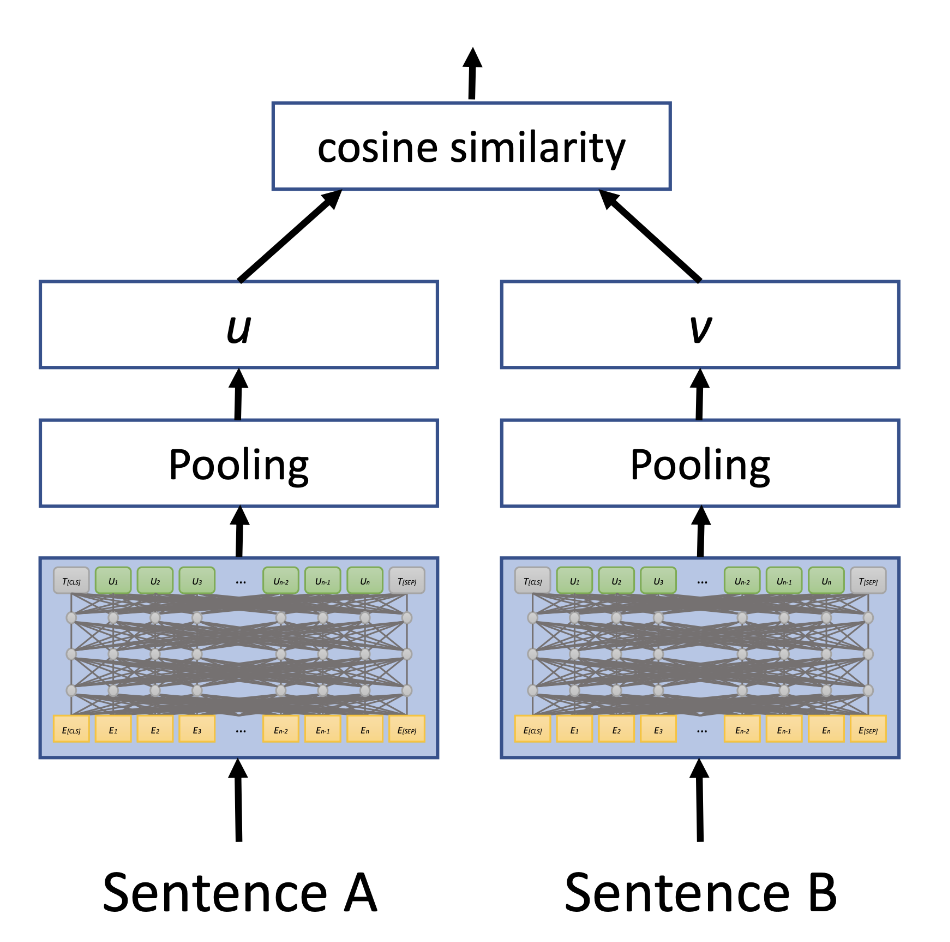 |

Выполните следующие задания:
* Внесите необходимые изменения в код и обучите xlm-roberta-base в фомате bi-encoder.
* Постройте графики зависимости метрик от количества пройденных шагов.
* Посчитайте метрики для финальной модели.
* Сколько времени заняло обучение?

Код обучения так же в ranking_lib

Запуск обучения:

`python train.py lightning.model.model_name="xlm-roberta-base" exp_name="xlm-roberta-base-bi_encoder-fp16" datamodule.train_dataloader.batch_size=96 +lightning=bi_encoder model_type=bi_encoder ++trainer.precision=16`


#### Ответы

`xlm-roberta-base`: 
* NDCG@3=0.629
* NDCG@10=0.714
* MRR@3=0.568
* MRR@10=0.601

`bert-multilingual-passage-reranking-msmarco`
* NDCG@3=0.653
* NDCG@10=0.723
* MRR@3=0.612
* MRR@10=0.64

Обучение 15к итераций заняло 19,5 часов. Это намного дольше, чем обучать cross-encoder

### Сравнение cross-encoder и bi-encoder архитектур \[2 балла\]

Вывод
* Обучать кросс-энкодер значительно быстрее, чем би-энкодер, так как требуется намного меньше операций на forward backward для одной итерации обучения.
* Инференс bi-encodera значительно быстрее, так как нам нужно получать только один embedding query, эмбеддинги документов можем хранить в векторной бд. Для кросс-энкодера нам каждый раз нужно прогонять всю выдачу для ранжирования.


### Дополнительно \[10 баллов\]

Вы можете получить дополнительные баллы, выполнив одно или несколько заданий:
* Обучите cross-encoder в fp16 с использованием AMP, посчитайте метрики, есть ли изменения? **[1 балла]**
* Реализуйте семплирование примеров с учетом их длинны, насколько ускорилось обучение cross-encoder? **[1 балла]**
* Попробуйте увеличить метрики bi-encoder за счет использования другого претрейна. Кроме xlm-roberta-base на [Huggingface](https://huggingface.co/models) есть большое количество предобученных моделей BERT. Датасет содержит тексты на русском языке, поэтому стоит обратить внимание на русскоязычные или мультиязычные претрейны. Если вам удасться улучшить метрику, то предположите, какие отличия претрейна на это повлияли. **[2 балла]**
* Попробуйте разморозить больше параметров модели (например, последний трансформерный слой). Как изменилось качество и скорость обучения? **[2 балла]**
* Попробуйте использовать listwise лосс для обучения модели, как изменились метрики? **[4 балла]**

#### Обучите cross-encoder в fp16 с использованием AMP, посчитайте метрики, есть ли изменения? **[1 балла]**

Метрики либо такие же, либо незначительно хуже. Эксперимент подтверждает идею, что сейчас трансформеры квантуют в 4 бита и вроде бы не теряют в качестве. Так же значительно ускорилось время обучения, например, кросс-энкодер учится в 4 раза бвстрее не 4 часа, а один.

#### Попробуйте увеличить метрики bi-encoder за счет использования другого претрейна. Кроме xlm-roberta-base на [Huggingface](https://huggingface.co/models) есть большое количество предобученных моделей BERT. Датасет содержит тексты на русском языке, поэтому стоит обратить внимание на русскоязычные или мультиязычные претрейны. Если вам удасться улучшить метрику, то предположите, какие отличия претрейна на это повлияли. **[2 балла]**

Был взят мультиязычный претрейн берта на мсмарко. При беглом тесте распределение кол-ва токенов на текстах очень похоже на xlm-roberta.
Удалось получить лучшие метрики, считаю, что из-за претрейна на msmarco. Также в этой модели в сеть подается маска token_type_ids принадлжености к последовательности, разделенной sep_token, в отличие от xlm-roberta-base. Думаю, это так же позволяет этой модели лучше работать в качестве кросс-энкодера: она понимает, какие токены принадлежат запросу, а какие документу.

### Попробуйте разморозить больше параметров модели (например, последний трансформерный слой). Как изменилось качество и скорость обучения? **[2 балла]**

Сравниваем с базовым экспериментом "xlm-roberta-base-only-head"

В остальных экспериментах были разморожены два последних слоя, метрики увеличились, обучение стало дольше в сравнении с обучением только слоя предсказания скора.